In [5]:
# Provide the filename of your hyperparam.json file
hyper_params_json_filename = '2023.07.10@01-19-51@hyperparams.json'

# Evaluate the model (on Arbitrary Datasets)

In [2]:
# reload modules
from importlib import reload

# load pretrained segmentation models (written in pytorch)
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# torchvision
from torchviz import make_dot
import torchvision.transforms.v2 as TF

# torchmetrics
from torchmetrics.classification import Dice, BinaryJaccardIndex

# Serialize/Deserialize Json files
import json

# Data Augmentation
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

# get data/time with desired format
from datetime import datetime

time_format = "%Y.%m.%d@%H-%M-%S"

# work with images
import cv2
from PIL import Image

# slice Iterables and turn to GEN
from itertools import islice

# keep numpy use to a min
# as we store our torch.Tensors to GPU Vram but numpy in RAM (it only supports CPU)
import pandas as pd
import numpy as np
import random

# to have a progress bar
from tqdm import tqdm

# To use pretrained segmentation models (implement in PyTorch)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
# uncomment if wan't to globally aloow sns to handle plot style
# it adds unwanted style (i.e., grid) to .imshow()
# so better to use it a context manager to style only what I want
# >>> with sns.axes_style('darkgrid'):
# >>>     plt.imshow(...)
# sns.set_theme(
#     context="notebook",
#     style="darkgrid",
#     palette="deep",
#     font="sans-serif",
#     font_scale=1,
#     color_codes=True,
#     rc={'axes.grid': False},
# )

# OS/File/Path management
import sys
import os

# load my custom Classes/Functions/etc.
from utils.dataset import get_loaders, SegmentaionDataset
from utils.models.unet import UnetScratch
from utils.visualization import (
    image_mask_plot,
    ImageAntiStandardize,
    plot_metrics
)

/home/tekboart/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/tekboart/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

## Set up GPU use


In [3]:
print("PyTorch ver:", torch.__version__)

# set max_split_size_mb to avoid GPU VRAM (out of MEM error)
# Could use terminal/shell instead:
# for linux: export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# for winows: set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# force pytorch to use GPU
# use "model.to(device)" later on to force a model use Cuda GPU
print("Can I use GPU?", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used for calculation (CPU\Cuda):", device)

PyTorch ver: 2.0.1+cu118
Can I use GPU? True
Device used for calculation (CPU\Cuda): cuda:0


## Load the Hyperparameters

In [6]:
hyperparams_path = os.path.join("outputs", "hyperparams", "")
#TODO: remember to update the hyperparam.json file (as everything depend on this)
hyperparams_filename = hyper_params_json_filename
hyperparams_addr = hyperparams_path + hyperparams_filename

with open(hyperparams_addr, 'r') as f:
    hyper_params = json.load(f)

# for backward compatibility and working with previos saved files
if not hyper_params.get('train_timestamp'):
    hyper_params['train_timestamp'] = '@'.join([i for i in hyperparams_filename.split('@')][:2])

# check the content of hyper_params
# pprint(hyper_params)

# if have used pretrained_model's 
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

## Remove sources of non-determinism

In [7]:
# use to seed the RNG for all devices (both CPU and CUDA).
torch.manual_seed(0)
# for custom operators, you might need to set python seed as well:
random.seed(0)
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG with:
np.random.seed(0)

# configure PyTorch to use deterministic algorithms instead of nondeterministic ones 
# A CAVEAT: throws an error if an operation is known to be nondeterministic (and without a deterministic alternative).
# that is why we used warn_only to avoid raising Error
torch.use_deterministic_algorithms(True, warn_only=True)
# CUDA convolution determinism
torch.backends.cudnn.deterministic = True

# -- DataLoader
# make it deterministic but allow it to random data order
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

DATA_LOADER_GEN = torch.Generator()
DATA_LOADER_GEN.manual_seed(0)

## Instantiate the model
> This obviosly must be the same model we have saved its checkpoint after training

In [8]:
model_arch = smp.UnetPlusPlus

model = model_arch(
    encoder_name=hyper_params['pretrained_model_encoder'],
    encoder_weights="imagenet",
    in_channels=hyper_params['input_channels'],
    classes=hyper_params['num_classes'],
)

preprocess_input = get_preprocessing_fn(
    hyper_params['pretrained_model_encoder'], pretrained='imagenet')

## Load a dataset to test the model with (e.g., Test set)

In [9]:
from utils import dataset
reload(dataset)

# we don't want TTA, just some resize, normalization, etc.
val_transform = A.Compose(
    [
        A.Resize(
            height=hyper_params["image_height"], width=hyper_params["image_width"]
        ),
    ],
)

eval_batch_size = 4

train_ds = SegmentaionDataset(
    image_dir=hyper_params['train_img_dir'],
    mask_dir=hyper_params['train_mask_dir'],
    transform=val_transform,
    preprocess_fn=preprocess_input,
    mask_suffix="",
    # subset=[0, 10],
)
val_ds = SegmentaionDataset(
    image_dir=hyper_params['val_img_dir'],
    mask_dir=hyper_params['val_mask_dir'],
    transform=val_transform,
    preprocess_fn=preprocess_input,
    mask_suffix="",
    # subset=[0, 5],
)
test_ds = SegmentaionDataset(
    image_dir=hyper_params['test_img_dir'],
    mask_dir=hyper_params['test_mask_dir'],
    transform=val_transform,
    preprocess_fn=preprocess_input,
    mask_suffix="",
    # subset=[0, 5],
)

# Create Datatset by data loaders
train_loader, val_loader, test_loader = get_loaders(
    train_ds,
    val_ds,
    test_ds,
    batch_size=eval_batch_size,
    num_workers=hyper_params['num_workers'],
    pin_memory=hyper_params['pin_mem'],
    worker_init_fn=seed_worker,
    generator=DATA_LOADER_GEN,
)

print("# train images:", len(train_ds))
print("# val images:", len(val_ds))
print("# test images:", len(test_ds))

# train images: 1896
# val images: 348
# test images: 1124


## Visualize Test Dataset(s)


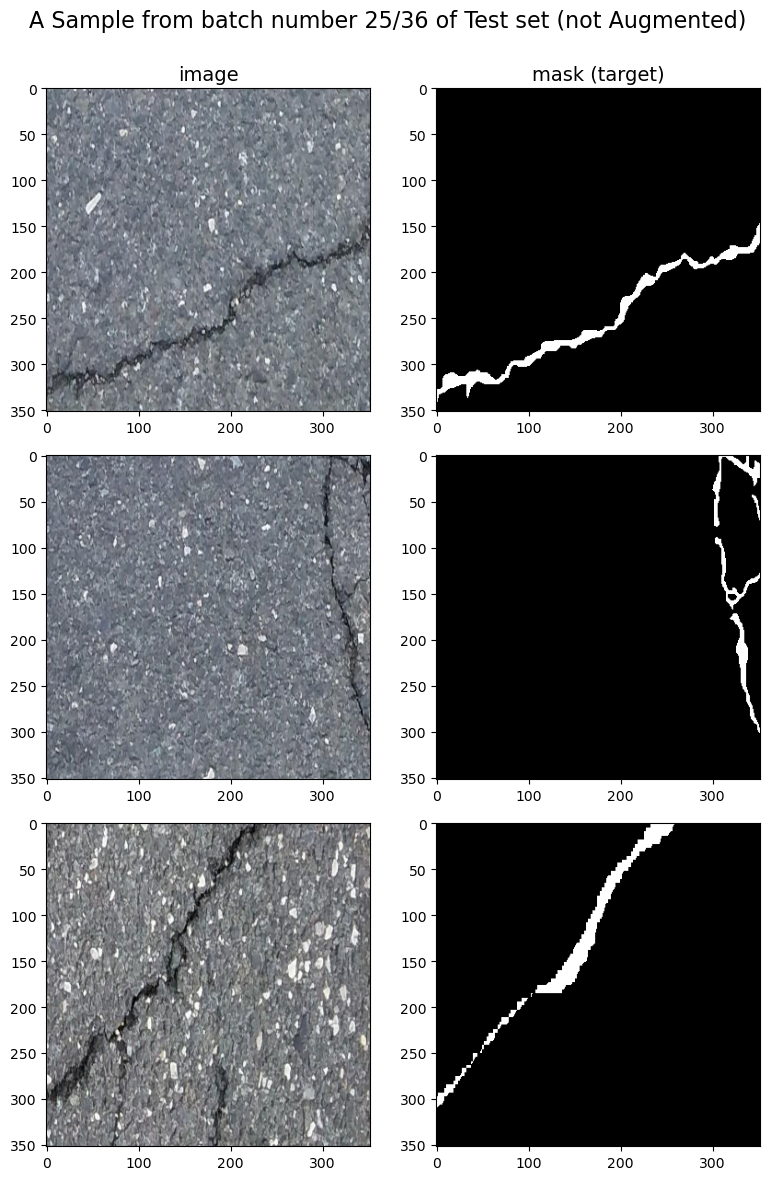

In [8]:
# Get a batch of data
num_batches = test_ds.pred_num_batches(hyper_params['batch_size'])

if num_batches > 1:
    batch_idx = random.randint(1, num_batches) - 1 # which mini_batch to get?
    test_batch = next(islice(iter(test_loader), batch_idx - 1, batch_idx))
else:
    batch_idx = 0
    test_batch = next(iter(test_loader))

# split the batch to img, mask (each a 4D-Tensor)
img_batch = test_batch[0]
mask_batch = test_batch[1]

image_mask_plot(
    [img_batch, mask_batch],
    data_format="channels_first",
    num_rows=3,
    plot_axes=True,
    anti_standardize_fn=ImageAntiStandardize(IMAGENET_MEAN, IMAGENET_STD),
)

plt.suptitle(f"A Sample from batch number {batch_idx+1}/{num_batches} of Test set (not Augmented)\n", fontsize=16)
plt.tight_layout()
plt.show()

## Load the saved checkpoint to model

In [11]:
model = smp.UnetPlusPlus(encoder_name=hyper_params['pretrained_model_encoder'],
                         encoder_weights="imagenet",
                         )

saved_model_path = f'models{os.sep}{hyper_params["train_timestamp"]}@model_checkpoint.pth.tar'

# get the checkpoint
checkpoint = torch.load(saved_model_path)

# set the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Backward Compatibility: in old checkpoints saves I've used 'state_dict
if state := checkpoint.get('model_state_dict'):
    model.load_state_dict(checkpoint['model_state_dict'])
elif state := checkpoint.get('state_dict'):
    model.load_state_dict(checkpoint['state_dict'])

# load the state of optimizer
# if want to resume training, e.g., from a temp_file saved at the of epoch
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [12]:
from utils.metrics import (
    AccuracyBinarySegment,
    DiceBinarySegment,
    JaccardBinarySegment,
    PrecisionBinarySegment,
    RecallBinarySegment,
    F1BinarySegment,
)
from utils.training import fit_fn
import utils.training
import utils.metrics

reload(utils.training)
reload(utils.metrics)

# a dict to map metrics' name to correspoing fn
metrics = {
    "accuracy": AccuracyBinarySegment(from_logits=True),  # remove as its very misleading
    "jaccard (IOU)": JaccardBinarySegment(from_logits=True),  # my custom jaccard
    "recall": RecallBinarySegment(from_logits=True),
    "precision": PrecisionBinarySegment(from_logits=True),
    "dice (F1 Score)": DiceBinarySegment(from_logits=True),  # my custom dice
    # "f1 score": F1BinarySegment(from_logits=True),  # is redundant as is the same as Dice
}

## Evaluate the saved model

### Evaluate only the Test Set
> We normaly report only the test set value. As train, val metrics are biased (knowledge leakage).

In [13]:
from utils.training import evaluate_fn, predict_fn


metrics_list = ["loss"] + list(metrics)

# go to inference mode
model.eval()  # no need as this line exists in validation_fn
model.to(device)

history_test = evaluate_fn(
    test_loader,
    model,
    loss_fn,
    dict.fromkeys(metrics_list, 0),
    metrics,
    device,
)

In [14]:
df = pd.DataFrame(history_test, index=[0])
df.to_csv(f"outputs{os.sep}history{os.sep}{hyper_params['train_timestamp']}@history_evaluation_test.csv", index=False)
print(" Metrics for Evaluation on Test Set ".center(79, " "))
display(df)
del df

                       Metrics for Evaluation on Test Set                      


,loss,accuracy,jaccard (IOU),recall,precision,dice (F1 Score)
0,0.080391,0.970402,0.56135,0.716957,0.727365,0.710545


### Evaluate the train, val, and Test Sets

In [15]:
# go to inference mode
model.eval()  # no need as this line exists in validation_fn
model.to(device)

history_train = evaluate_fn(
    train_loader,
    model,
    loss_fn,
    dict.fromkeys(metrics_list, 0),
    metrics,
    device,
)

# go to inference mode
model.eval()  # no need as this line exists in validation_fn
model.to(device)

#TODO: make it part of the evaluate_fn (by just getting the metrics as a list)
val_metrics_init = dict.fromkeys(metrics_list, 0)

history_val = evaluate_fn(
    val_loader,
    model,
    loss_fn,
    val_metrics_init,
    metrics,
    device,
)

In [16]:
a = pd.Series(history_train, name='Train')
b = pd.Series(history_val, name='Val')
c = pd.Series(history_test, name='Test')

df = pd.concat([a, b, c], axis=1)
df.to_csv(f"outputs{os.sep}history{os.sep}{hyper_params['train_timestamp']}@history_evaluation_train_val_test.csv", index=True)
print('Model evaluation on diff sets')
display(df)
del df

Model evaluation on diff sets


,Train,Val,Test
loss,0.034622,0.058647,0.080391
accuracy,0.985623,0.978765,0.970402
jaccard (IOU),0.784756,0.658090,0.561350
recall,0.869250,0.779525,0.716957
precision,0.888181,0.812452,0.727365
dice (F1 Score),0.878336,0.786358,0.710545
